In [ ]:
!pip install opencv-contrib-python

Starte Herzfrequenz-Analyse...
1. Video wird geladen und verarbeitet...
2. Signal wurde erfolgreich gefiltert...
3. Herzschläge wurden erkannt...

=== ANALYSEERGEBNIS ===
Gemessene Herzfrequenz: 76.60 BPM
Anzahl erkannter Herzschläge: 13
ROI-Koordinaten: (512, 216, 256, 72)

4. Erstelle Visualisierung...


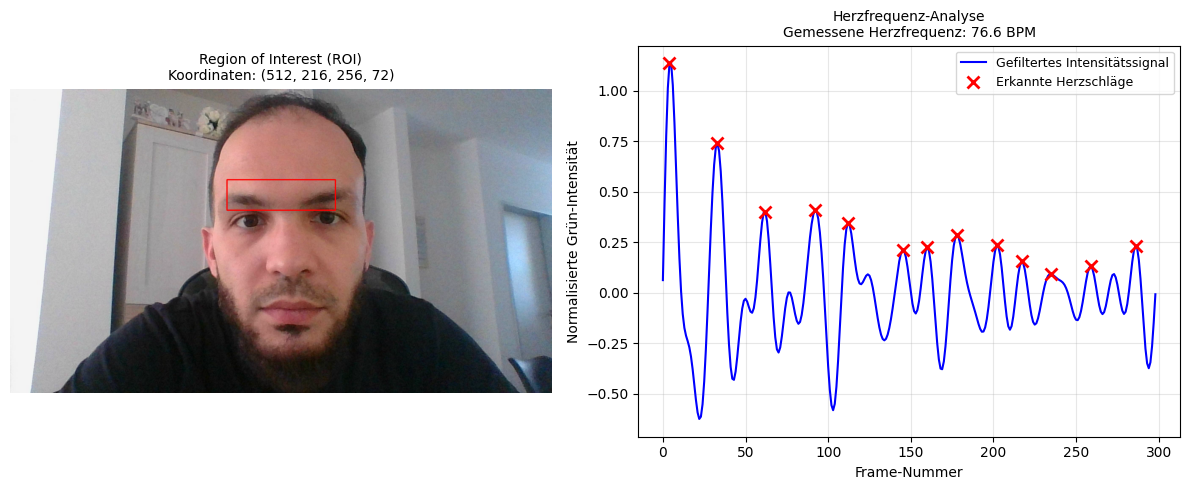

Analyse erfolgreich abgeschlossen!


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt, find_peaks

def analyze_video_heartrate(video_file_path):
    """
    Analysiert ein Video zur Bestimmung der Herzfrequenz über Farbveränderungen
    
    Parameter:
    video_file_path (str): Pfad zur Video-Datei
    
    Rückgabe:
    tuple: (herzfrequenz, gefiltertes_signal, peak_positionen, roi_frame, roi_koordinaten)
    """
    
    # Video-Capture-Objekt erstellen um das Video Frame für Frame zu lesen
    # Eine Verbindung zu einer Videodatei herstellt.
    video_capture = cv2.VideoCapture(video_file_path)
    
    # Liste zum Speichern der durchschnittlichen Grün-Intensitätswerte pro Frame
    green_intensity_values = []
    
    # Variable für das erste Frame mit eingezeichneter ROI (Region of Interest)
    frame_with_marked_roi = None
    
    # Schleife durch alle Frames des Videos
    # isOpened(): Überprüft, ob die Videodatei erfolgreich geöffnet wurde.
    while video_capture.isOpened():
        # Nächstes Frame aus dem Video lesen
        # current_frame: Der aktuelle Frame als Numpy-Array, wenn der Frame erfolgreich gelesen wurde. Wenn nicht, ist dieser Wert oft None oder ein leerer Array.
        frame_successfully_read, current_frame = video_capture.read()
        # print("fr",frame_successfully_read)
        # print("cur", current_frame)
        # Wenn kein Frame mehr gelesen werden kann, Video ist zu Ende
        if not frame_successfully_read: 
            break
        
        # Frame-Dimensionen extrahieren (Höhe und Breite)
        # 3. in shape: Kanäle (Channels): Die Anzahl der Farbkanäle (normalerweise 3 für RGB oder BGR).
        frame_height, frame_width = current_frame.shape[:2]
        #print("current_frame.shape", current_frame.shape)
        
        # ROI (Region of Interest) Koordinaten berechnen
        # ROI ist ein rechteckiger Bereich, der typischerweise die Stirn abdeckt
        roi_start_x = int(frame_width * 0.4)    # 40% von links als Startpunkt
        roi_start_y = int(frame_height * 0.3)   # 30% von oben als Startpunkt  
        roi_width = int(frame_width * 0.2)      # ROI ist 20% der Bildbreite breit
        roi_height = int(frame_height * 0.1)    # ROI ist 10% der Bildhöhe hoch
        
        # Beim ersten Frame: ROI-Bereich auf dem Frame markieren für Visualisierung
        if frame_with_marked_roi is None:
            # Frame von BGR (OpenCV Standard) zu RGB (matplotlib Standard) konvertieren
            rgb_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
            # Kopie des Frames erstellen um das Original nicht zu verändern
            frame_with_marked_roi = rgb_frame.copy()
            # Rotes Rechteck um die ROI zeichnen (255,0,0 = rot, 2 = Linienstärke)
            cv2.rectangle(frame_with_marked_roi, 
                         (roi_start_x, roi_start_y), 
                         (roi_start_x + roi_width, roi_start_y + roi_height), 
                         (255, 0, 0), 2)
        
        # Grün-Kanal aus der ROI extrahieren
        # Der Grün-Kanal ist am sensitivsten für Durchblutungsveränderungen
        # Der Index 1 am Ende bezieht sich auf den Grün-Kanal im RGB-Bild. In RGB ist die Reihenfolge der Kanäle: 0 für Rot, 1 für Grün und 2 für Blau.
        rgb_converted_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
        roi_green_channel = rgb_converted_frame[roi_start_y:roi_start_y + roi_height, 
                                              roi_start_x:roi_start_x + roi_width, 1]
        
        #print("roi_green_channel", roi_green_channel)
        # Das Ergebnis roi_green_channel ist ein 2D-Array, das nur die Grün-Werte der Pixel in der definierten ROI enthält.
        # Durchschnittliche Intensität des Grün-Kanals in der ROI berechnen
        average_green_intensity = np.mean(roi_green_channel)
        #print("roi_green_channel_ave", average_green_intensity)
        # Intensitätswert zur Liste hinzufügen
        green_intensity_values.append(average_green_intensity)
    
    # Video-Ressourcen freigeben
    video_capture.release()
    
    # Überprüfung ob genügend Frames für die Filterung vorhanden sind
    # Butterworth-Filter benötigt mindestens 3*Ordnung + 1 Samples
    minimum_frames_required = 16  # Für Filter 5. Ordnung
    if len(green_intensity_values) <= minimum_frames_required:
        raise ValueError(f"Video zu kurz für Analyse. Mindestens {minimum_frames_required + 1} Frames benötigt.")
    
    # === SIGNAL-FILTERUNG ===
    # Butterworth-Bandpassfilter zur Rauschunterdrückung und Frequenzbereich-Einschränkung
    
    # Parameter für die Filterung
    sampling_frequency = 30        # Angenommene Video-Framerate in Hz
    filter_order = 5               # Filterordnung (höher = steilere Flanken)
    lower_cutoff_frequency = 0.83  # Untere Grenzfrequenz in Hz (50 BPM)
    upper_cutoff_frequency = 2.5   # Obere Grenzfrequenz in Hz (150 BPM)
    
    # Nyquist-Frequenz berechnen (halbe Sampling-Frequenz)
    nyquist_frequency = sampling_frequency / 2
    
    # Butterworth-Filter-Koeffizienten berechnen
    # Frequenzen müssen auf Nyquist-Frequenz normalisiert werden
    # Die Koeffizienten für einen Butterworth-Filter berechnen.
    filter_coefficients_b, filter_coefficients_a = butter( # Die Koeffizienten des Zählerpolynoms des Filters, Die Koeffizienten des Nennerpolynoms des Filters.
        filter_order, 
        [lower_cutoff_frequency / nyquist_frequency, upper_cutoff_frequency / nyquist_frequency], 
        btype='band'  # Bandpassfilter (lässt nur Frequenzen in einem bestimmten Bereich durch)
    )
    
    # Filter auf das Signal anwenden (vorwärts und rückwärts für Phasen-Neutralität)
    filtered_intensity_signal = filtfilt(filter_coefficients_b, filter_coefficients_a, green_intensity_values)
    
    # === PEAK-DETEKTION UND HERZFREQUENZ-BERECHNUNG ===
    
    # Mindestabstand zwischen Peaks in Frames berechnen
    # Bei 30 fps entspricht ein Abstand von 15 Frames einer maximalen Herzfrequenz von 120 BPM
    minimum_peak_distance = int(sampling_frequency / 2)  # 15 Frames
    
    # Peaks (lokale Maxima) im gefilterten Signal finden
    # Detected_peak_positions: Ein Array mit den Positionen der gefundenen Peaks im Signal.
    # peak_properties: Ein Dictionary mit zusätzlichen Eigenschaften der Peaks, wie z.B. die Höhe und Breite der Peaks.
    detected_peak_positions, peak_properties = find_peaks(
        filtered_intensity_signal, 
        distance=minimum_peak_distance  # Mindestabstand zwischen Peaks
    )
    
    # Überprüfung ob genügend Peaks für Herzfrequenz-Berechnung gefunden wurden
    if len(detected_peak_positions) < 2:
        raise ValueError("Zu wenige Herzschläge erkannt. Versuchen Sie ein längeres Video oder bessere Beleuchtung.")
    
    # RR-Intervalle berechnen (Zeit zwischen aufeinanderfolgenden Herzschlägen)
    # diff() berechnet die Differenzen zwischen aufeinanderfolgenden Peak-Positionen
    rr_intervals_in_frames = np.diff(detected_peak_positions)
    
    # Durchschnittliches RR-Intervall in Sekunden umrechnen
    average_rr_interval_seconds = np.mean(rr_intervals_in_frames) / sampling_frequency
    
    # Herzfrequenz in Schlägen pro Minute (BPM) berechnen
    # Herzfrequenz = 60 Sekunden / durchschnittliches RR-Intervall
    calculated_heart_rate_bpm = 60.0 / average_rr_interval_seconds
    
    # ROI-Koordinaten als Tupel für Rückgabe
    roi_coordinates = (roi_start_x, roi_start_y, roi_width, roi_height)
    
    # Alle Ergebnisse zurückgeben
    return (calculated_heart_rate_bpm, 
            filtered_intensity_signal, 
            detected_peak_positions, 
            frame_with_marked_roi, 
            roi_coordinates)

def plot_analysis_results(filtered_signal, peak_positions, roi_frame, roi_coordinates, heart_rate_bpm):
    """
    Visualisiert die Ergebnisse der Herzfrequenz-Analyse
    
    Parameter:
    filtered_signal (array): Das gefilterte Intensitätssignal
    peak_positions (array): Positionen der erkannten Peaks
    roi_frame (array): Frame mit eingezeichneter ROI
    roi_coordinates (tuple): Koordinaten der ROI (x, y, breite, höhe)  
    heart_rate_bpm (float): Berechnete Herzfrequenz in BPM
    """
    
    # Matplotlib-Figure mit zwei Subplots erstellen
    plt.figure(figsize=(12, 5))
    
    # === ERSTER SUBPLOT: ROI-VISUALISIERUNG ===
    plt.subplot(1, 2, 1)  # 1 Zeile, 2 Spalten, Position 1
    
    # Frame mit markierter ROI anzeigen
    plt.imshow(roi_frame)
    
    # Titel mit ROI-Koordinaten
    roi_x, roi_y, roi_w, roi_h = roi_coordinates
    plt.title(f'Region of Interest (ROI)\nKoordinaten: ({roi_x}, {roi_y}, {roi_w}, {roi_h})', 
              fontsize=10)
    
    # Achsen ausblenden für bessere Bilddarstellung
    plt.axis('off')
    
    # === ZWEITER SUBPLOT: SIGNAL-ANALYSE ===
    plt.subplot(1, 2, 2)  # 1 Zeile, 2 Spalten, Position 2
    
    # Frame-Nummern für x-Achse erstellen
    frame_numbers = np.arange(len(filtered_signal))
    
    # Gefiltertes Signal als blaue Linie plotten
    plt.plot(frame_numbers, filtered_signal, 'b-', linewidth=1.5, label='Gefiltertes Intensitätssignal')
    
    # Erkannte Peaks als rote X-Markierungen plotten
    plt.plot(peak_positions, filtered_signal[peak_positions], 'rx', 
             markersize=8, markeredgewidth=2, label='Erkannte Herzschläge')
    
    # Achsenbeschriftungen und Titel
    plt.xlabel('Frame-Nummer', fontsize=10)
    plt.ylabel('Normalisierte Grün-Intensität', fontsize=10)
    plt.title(f'Herzfrequenz-Analyse\nGemessene Herzfrequenz: {heart_rate_bpm:.1f} BPM', 
              fontsize=10)
    
    # Legende anzeigen
    plt.legend(fontsize=9)
    
    # Gitter für bessere Ablesbarkeit hinzufügen
    plt.grid(True, alpha=0.3)
    
    # Layout optimieren um Überlappungen zu vermeiden
    plt.tight_layout()
    
    # Grafik anzeigen
    plt.show()

# === HAUPTPROGRAMM ===

# Pfad zur Video-Datei definieren
video_file_path = r'D:\Bachelor\Informatik 1.Semester\Bilder\Camera Roll\WIN_20250619_17_20_49_Pro.mp4'

# Überprüfen ob die Video-Datei existiert
if not os.path.exists(video_file_path):
    print("FEHLER: Video-Datei wurde nicht gefunden!")
    print(f"Überprüfter Pfad: {video_file_path}")
else:
    # Try-Catch Block für Fehlerbehandlung
    try:
        print("Starte Herzfrequenz-Analyse...")
        print("1. Video wird geladen und verarbeitet...")
        
        # Hauptanalyse-Funktion aufrufen
        (measured_heart_rate, 
         processed_signal, 
         heartbeat_peaks, 
         roi_visualization_frame, 
         region_coordinates) = analyze_video_heartrate(video_file_path)
        
        print("2. Signal wurde erfolgreich gefiltert...")
        print("3. Herzschläge wurden erkannt...")
        
        # Ergebnis in der Konsole ausgeben
        print(f"\n=== ANALYSEERGEBNIS ===")
        print(f"Gemessene Herzfrequenz: {measured_heart_rate:.2f} BPM")
        print(f"Anzahl erkannter Herzschläge: {len(heartbeat_peaks)}")
        print(f"ROI-Koordinaten: {region_coordinates}")
        
        print("\n4. Erstelle Visualisierung...")
        
        # Ergebnisse grafisch darstellen
        plot_analysis_results(processed_signal, 
                            heartbeat_peaks, 
                            roi_visualization_frame, 
                            region_coordinates, 
                            measured_heart_rate)
        
        print("Analyse erfolgreich abgeschlossen!")
        
    except ValueError as analysis_error:
        print(f"ANALYSE-FEHLER: {analysis_error}")
        print("Mögliche Lösungen:")
        print("- Verwenden Sie ein längeres Video (mindestens 5-10 Sekunden)")
        print("- Sorgen Sie für bessere Beleuchtung")
        print("- Halten Sie die Kamera ruhiger")
        
    except Exception as unexpected_error:
        print(f"UNERWARTETER FEHLER: {unexpected_error}")
        print("Bitte überprüfen Sie die Video-Datei und versuchen Sie es erneut.")